Module config

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np

import scipy.stats as sp

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import savefig

Seaborn config

In [2]:
% matplotlib inline
sns.set(style='white')

Filesystem config

In [3]:
source_dir = Path().absolute().parents[1] / 'derivatives' / '0.4.joined'
figures_dir = Path().absolute().parents[1] / 'derivatives' / 'figures'

Import data

In [4]:
data = pd.read_csv( source_dir / 'all_subject_level.csv' )

Quick cleaning

In [5]:
data['Condition'] = data['Condition'].map({1:'Annotated',2:'Video',3:'Original'})
data['SciField'] = data['SciField'] - 1
data['Gender'] = data['Gender'] - 1
data['nb_CoR'] = data['nb_CoR']*100
data[['SciEdu_HS','SciEdu_UGrad','SciEdu_Grad']] = data[['SciEdu_HS','SciEdu_UGrad','SciEdu_Grad']].replace({np.nan:0})
data.head()

,sub,Condition,Age,Gender,Major,Major_TEXT,SciDegree,SciDegree_TEXT,EduYears,SciEdu_HS,...,SciLit_sum,SciTudeA_sum,SciTudeL_sum,SciTudeS_sum,O1_sum,O2_sum,O3_sum,O4_sum,O5_sum,O6_sum
0,101,Annotated,20.0,1.0,5.0,biomedical-science,NaN,NaN,14,4,...,4.0,25,21,24,9,14,17,9,12,13
1,102,Video,19.0,1.0,5.0,forensic-science,NaN,NaN,12,3,...,2.0,21,22,26,17,19,14,11,11,9
2,103,Original,18.0,0.0,2.0,communications,NaN,NaN,12,3,...,2.0,27,13,21,16,13,16,10,11,16
3,104,Annotated,18.0,0.0,5.0,statistics,NaN,NaN,12,4,...,2.0,30,20,27,17,13,20,14,15,13
4,105,Video,18.0,0.0,5.0,biomedical-science,NaN,NaN,12,6,...,4.0,21,13,28,17,13,12,12,10,13


# Demographics

In [6]:
(data.groupby(['AgeGroup', 'Condition'], as_index=False)
    .agg({'sub':'count', 'Age':'mean', 'Gender':'mean'})
    .rename({'sub':'Count', 'Age':'Mean Age', 'Gender':'% Female'}, axis=1))

,AgeGroup,Condition,Count,Mean Age,% Female
0,OA,Annotated,15,71.400000,0.666667
1,OA,Original,15,76.466667,0.733333
2,OA,Video,18,74.611111,0.611111
3,YA,Annotated,26,18.500000,0.653846
4,YA,Original,27,18.851852,0.518519
5,YA,Video,23,19.043478,0.652174


In [7]:
(data.groupby(['AgeGroup', 'Condition'], as_index=False)
    .agg({'sub':'count', 'comp_change':'mean', 'comp_t1':'mean', 'comp_t2':'mean'})
    .rename({'sub':'Count', 'comp_t1':'T1', 'comp_t2':'T2', 'comp_change':'Mean Diff'}, axis=1))

,AgeGroup,Condition,Count,Mean Diff,T1,T2
0,OA,Annotated,15,2.333333,11.333333,13.666667
1,OA,Original,15,3.400000,11.066667,14.466667
2,OA,Video,18,3.722222,10.555556,14.277778
3,YA,Annotated,26,2.730769,10.576923,13.307692
4,YA,Original,27,4.111111,9.629630,13.740741
5,YA,Video,23,3.826087,9.782609,13.608696


## Outlier Exclusion

In [8]:
data.columns

Index(['sub', 'Condition', 'Age', 'Gender', 'Major', 'Major_TEXT', 'SciDegree',
       'SciDegree_TEXT', 'EduYears', 'SciEdu_HS', 'SciEdu_UGrad',
       'SciEdu_Grad', 'SciField', 'AgeGroup', 'comp_t1', 'comp_t2',
       'comp_change', 'nb_RT', 'nb_CoR', 'procspd_RT', 'NFCS_sum', 'TSSI_sum',
       'vocab_sum', 'SciLit_sum', 'SciTudeA_sum', 'SciTudeL_sum',
       'SciTudeS_sum', 'O1_sum', 'O2_sum', 'O3_sum', 'O4_sum', 'O5_sum',
       'O6_sum'],
      dtype='object')

In [9]:
def exclude(data, colname, Z_bound=3, ddof=0):
    """  """
    Z = ((data[colname] - data[colname].mean()) / (data[colname].std(ddof=ddof)))
    Z = Z.where(abs(Z < Z_bound))
    Z.name = 'Z_'+ colname
    return( Z )

In [10]:
for colname in ('comp_change','nb_RT', 'nb_CoR', 'procspd_RT', 'NFCS_sum', 'TSSI_sum', 'vocab_sum',
                'SciLit_sum', 'SciTudeA_sum', 'SciTudeL_sum', 'SciTudeS_sum',
                'O1_sum', 'O2_sum', 'O3_sum', 'O4_sum', 'O5_sum', 'O6_sum'):
    data = data.join(exclude(data,colname))

# Group comparisons

In [11]:
vars_of_interest = ['comp_t1', 'comp_t2', 'comp_change', 'nb_CoR', 'nb_RT', 'procspd_RT',
                    'NFCS_sum','TSSI_sum', 'vocab_sum','SciLit_sum',
                    'SciTudeA_sum','SciTudeL_sum','SciTudeS_sum']

In [12]:
grps_of_interest = ['Condition','AgeGroup',['AgeGroup','Condition']]

# Correlations
We need to drop all missing data listwise. SPSS does this pairwise for the correlations, but I'm not sure how exactly to replicate that. If we find a way to, I would prefer not to destroy data unnecessarily here.

In [13]:
slim_data = data[['sub','AgeGroup','Condition']+vars_of_interest].dropna()

## Correlation Matrices

Define functions to create the correlation & significance tables and matrices

In [14]:
def corr_table(df):
    corr_df = pd.DataFrame()
    for c in vars_of_interest:
        for d in vars_of_interest:
            corr_df.loc[c,d] = sp.pearsonr(df[c],df[d])[0]
    return(corr_df)

def sig_table(df):
    sig_df = pd.DataFrame()
    for c in vars_of_interest:
        for d in vars_of_interest:
            sig_df.loc[c,d] = sp.pearsonr(df[c],df[d])[1]
    return(sig_df)

In [15]:
def matrix_mask(df):
    mask = np.zeros_like(df)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(16,5))
    return(mask)

In [16]:
def correlation_matrix(df,title):
    mask = matrix_mask(df)
    fig = sns.heatmap(df, mask=mask, annot=True, cmap='Spectral',
                      fmt='.3f', linewidths=1, center=0)
    fig.set_title(title+'\nCorrelation Coefficients')
    return(fig)

def significance_matrix(df,title):
    mask = matrix_mask(df)
    myColors = (
        (0.4, 0.0, 0.0, 1.00),(0.6, 0.0, 0.0, 0.85),(0.8, 0.0, 0.0, 0.70),(1.0, 0.0, 0.0, 0.55),
        (1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),
        (1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),
        (1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),
        (1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),
    )
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
    fig = sns.heatmap(df, mask=mask, annot=True, cmap=cmap,
                fmt='.3f', linewidths=1, center=0.5
               )
    fig.set_title(title+'\nCorrelation Significance')
    return(fig)

### All AgeGroups,Conditions

In [17]:
corr_df = corr_table(slim_data)
sig_df = sig_table(slim_data)

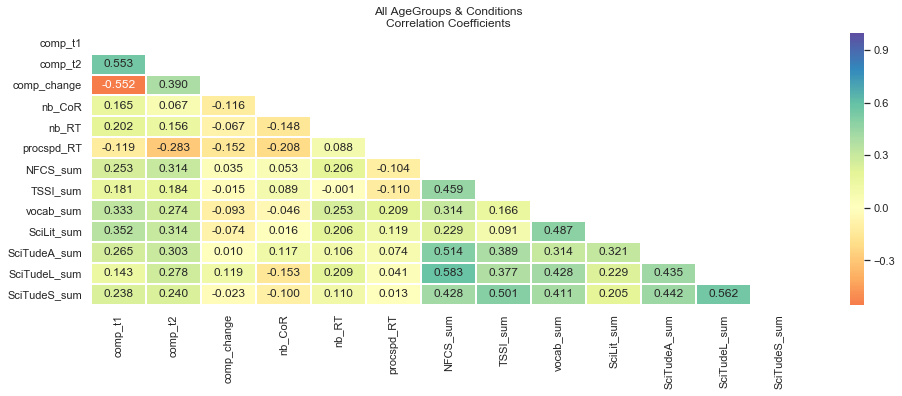

In [18]:
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_coeff_all.png'
fig = correlation_matrix(corr_df,'All AgeGroups & Conditions')
fig.get_figure().savefig(fpath, bbox_inches='tight')

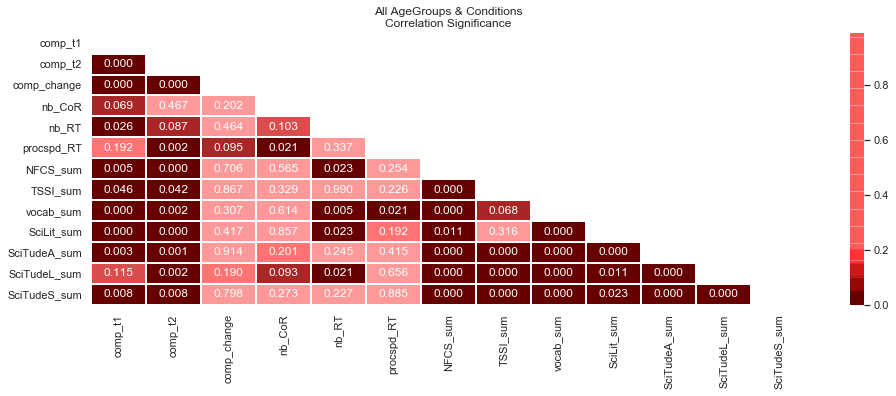

In [19]:
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_sig_all.png'
fig = significance_matrix(sig_df,'All AgeGroups & Conditions')
fig.get_figure().savefig(fpath, bbox_inches='tight')

### By AgeGroup

In [20]:
ya_data = slim_data[slim_data['AgeGroup'] == 'YA']
oa_data = slim_data[slim_data['AgeGroup'] == 'OA']

In [21]:
ya_corr_df = corr_table(ya_data)
ya_sig_df = sig_table(ya_data)
oa_corr_df = corr_table(oa_data)
oa_sig_df = sig_table(oa_data)

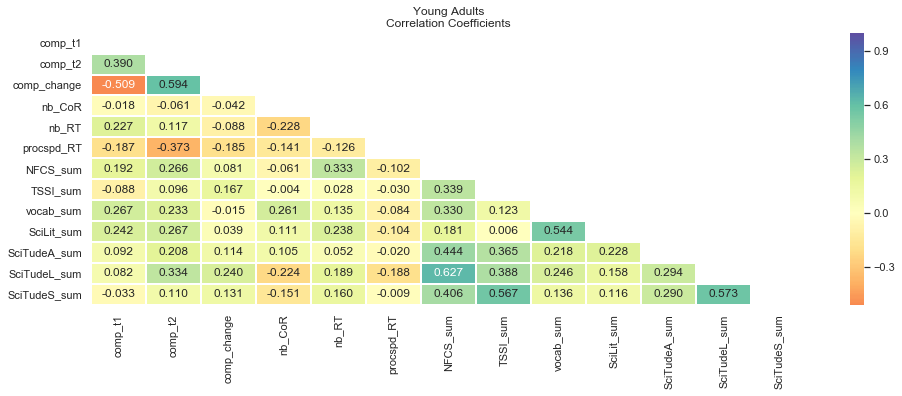

In [22]:
fig = correlation_matrix(ya_corr_df,'Young Adults')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_coeff_ya.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

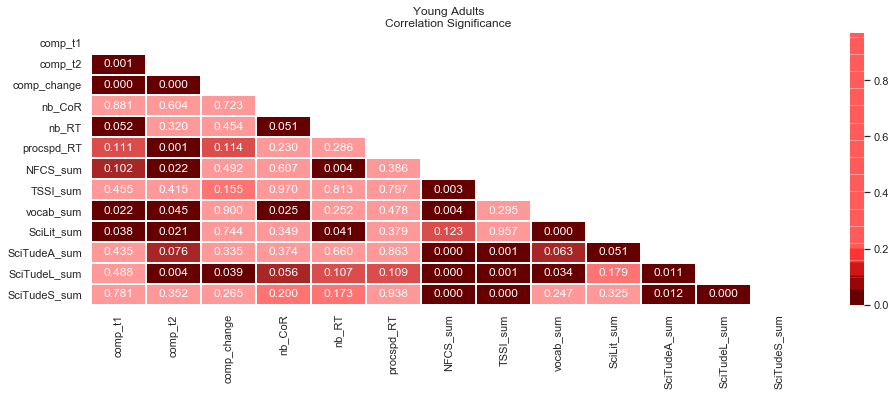

In [23]:
fig = significance_matrix(ya_sig_df,'Young Adults')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_sig_ya.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

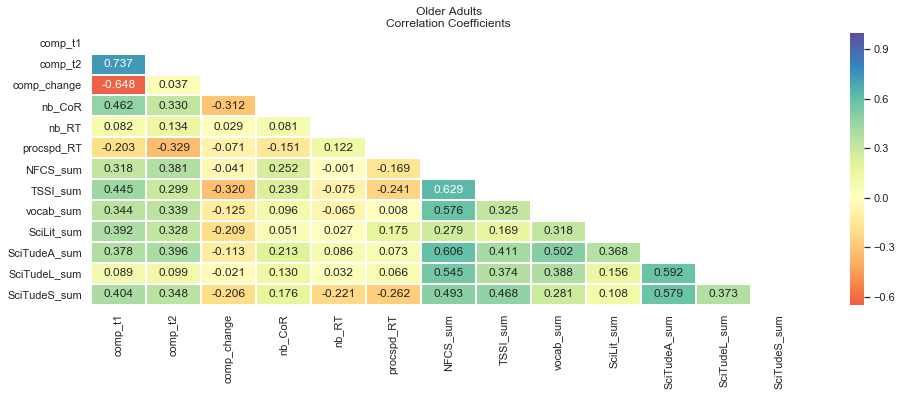

In [24]:
fig = correlation_matrix(oa_corr_df,'Older Adults')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_coeff_oa.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

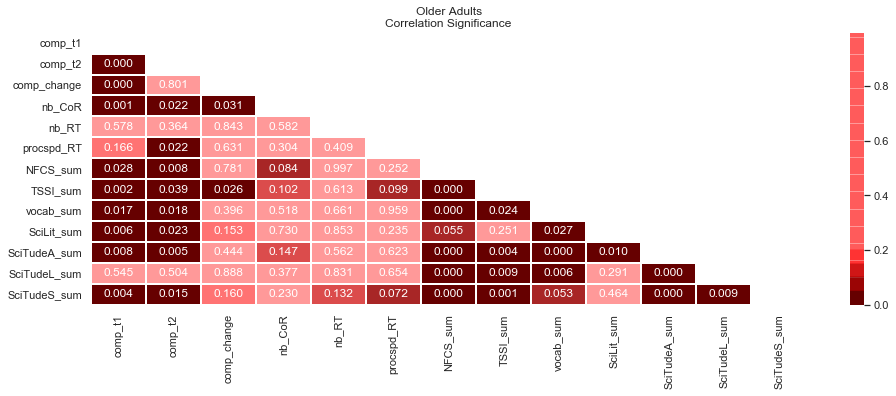

In [25]:
fig = significance_matrix(oa_sig_df,'Older Adults')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_sig_oa.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

### By Condition

In [26]:
annotated_data = slim_data[slim_data['Condition'] == 'Annotated']
original_data = slim_data[slim_data['Condition'] == 'Original']
video_data = slim_data[slim_data['Condition'] == 'Video']

In [27]:
annotated_corr_df = corr_table(annotated_data)
annotated_sig_df = sig_table(annotated_data)

original_corr_df = corr_table(original_data)
original_sig_df = sig_table(original_data)

video_corr_df = corr_table(video_data)
video_sig_df = sig_table(video_data)

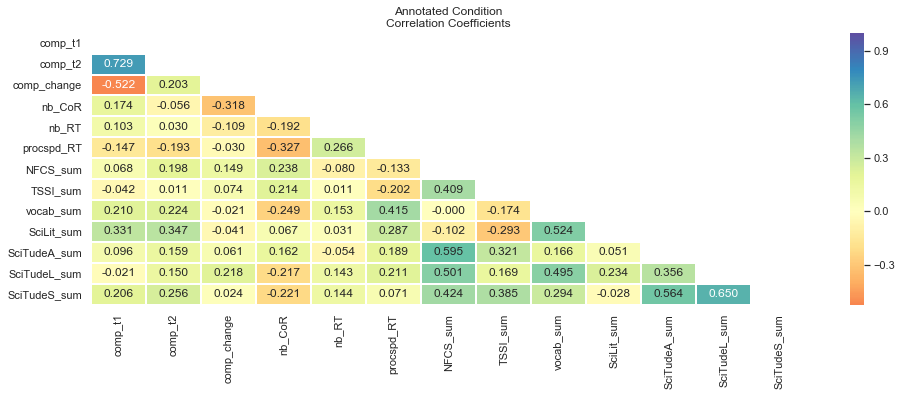

In [28]:
fig = correlation_matrix(annotated_corr_df,'Annotated Condition')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_coeff_annot.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

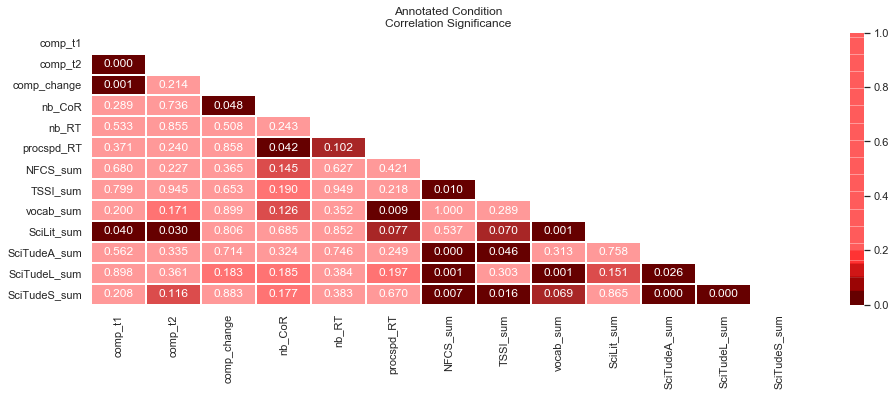

In [29]:
fig = significance_matrix(annotated_sig_df,'Annotated Condition')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_sig_annot.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

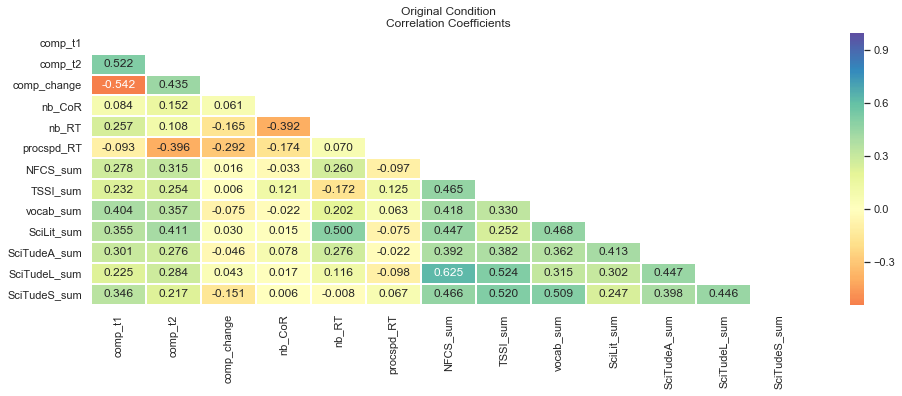

In [30]:
fig = correlation_matrix(original_corr_df,'Original Condition')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_coeff_orig.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

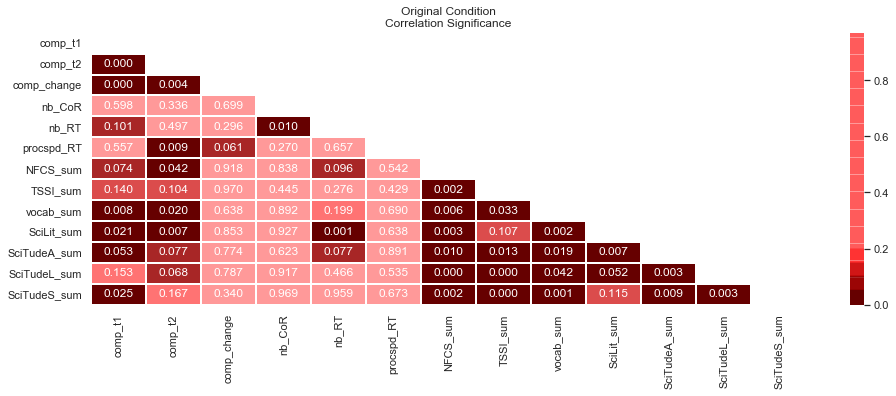

In [31]:
fig = significance_matrix(original_sig_df,'Original Condition')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_sig_orig.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

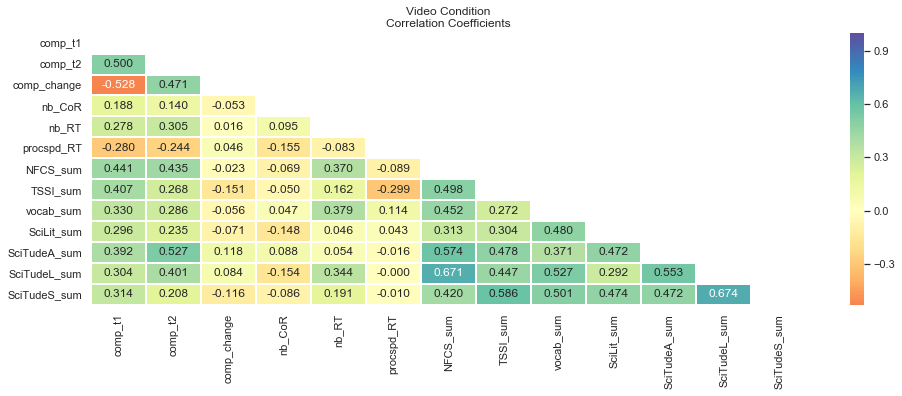

In [32]:
fig = correlation_matrix(video_corr_df,'Video Condition')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_coeff_video.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

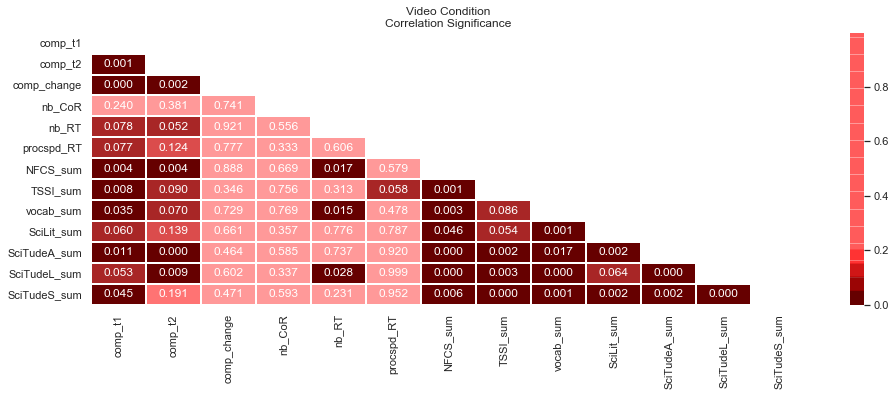

In [33]:
fig = significance_matrix(video_sig_df,'Video Condition')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_sig_video.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

## Correlograms

### Z correlograms with exclusions

In [37]:
zvars = ['Z_comp_change', 'Z_nb_RT', 'Z_nb_CoR', 'Z_procspd_RT', 
          'Z_NFCS_sum', 'Z_TSSI_sum', 'Z_vocab_sum']

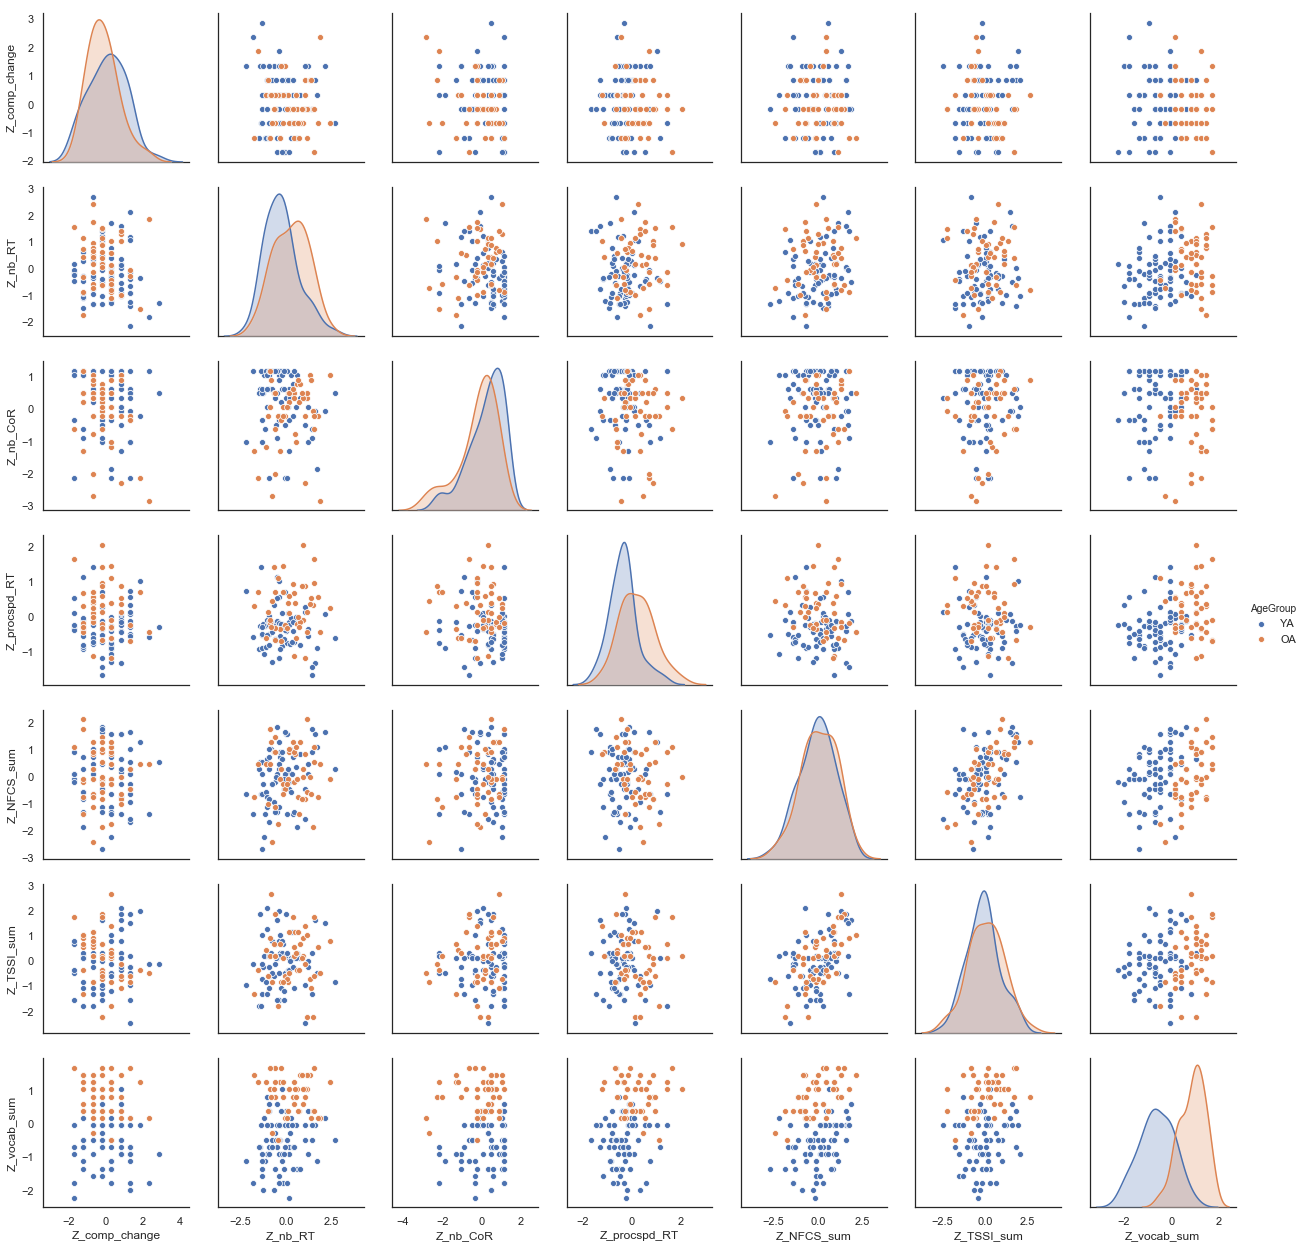

In [49]:
zx_selective_pairplot_agegroup = sns.pairplot(
    data[['AgeGroup'] + zvars].dropna(), hue='AgeGroup')
figpath = figures_dir / 'Z_selective_pairplot_agegroup.png'
zx_selective_pairplot_agegroup.savefig(figpath, bbox_inches='tight')

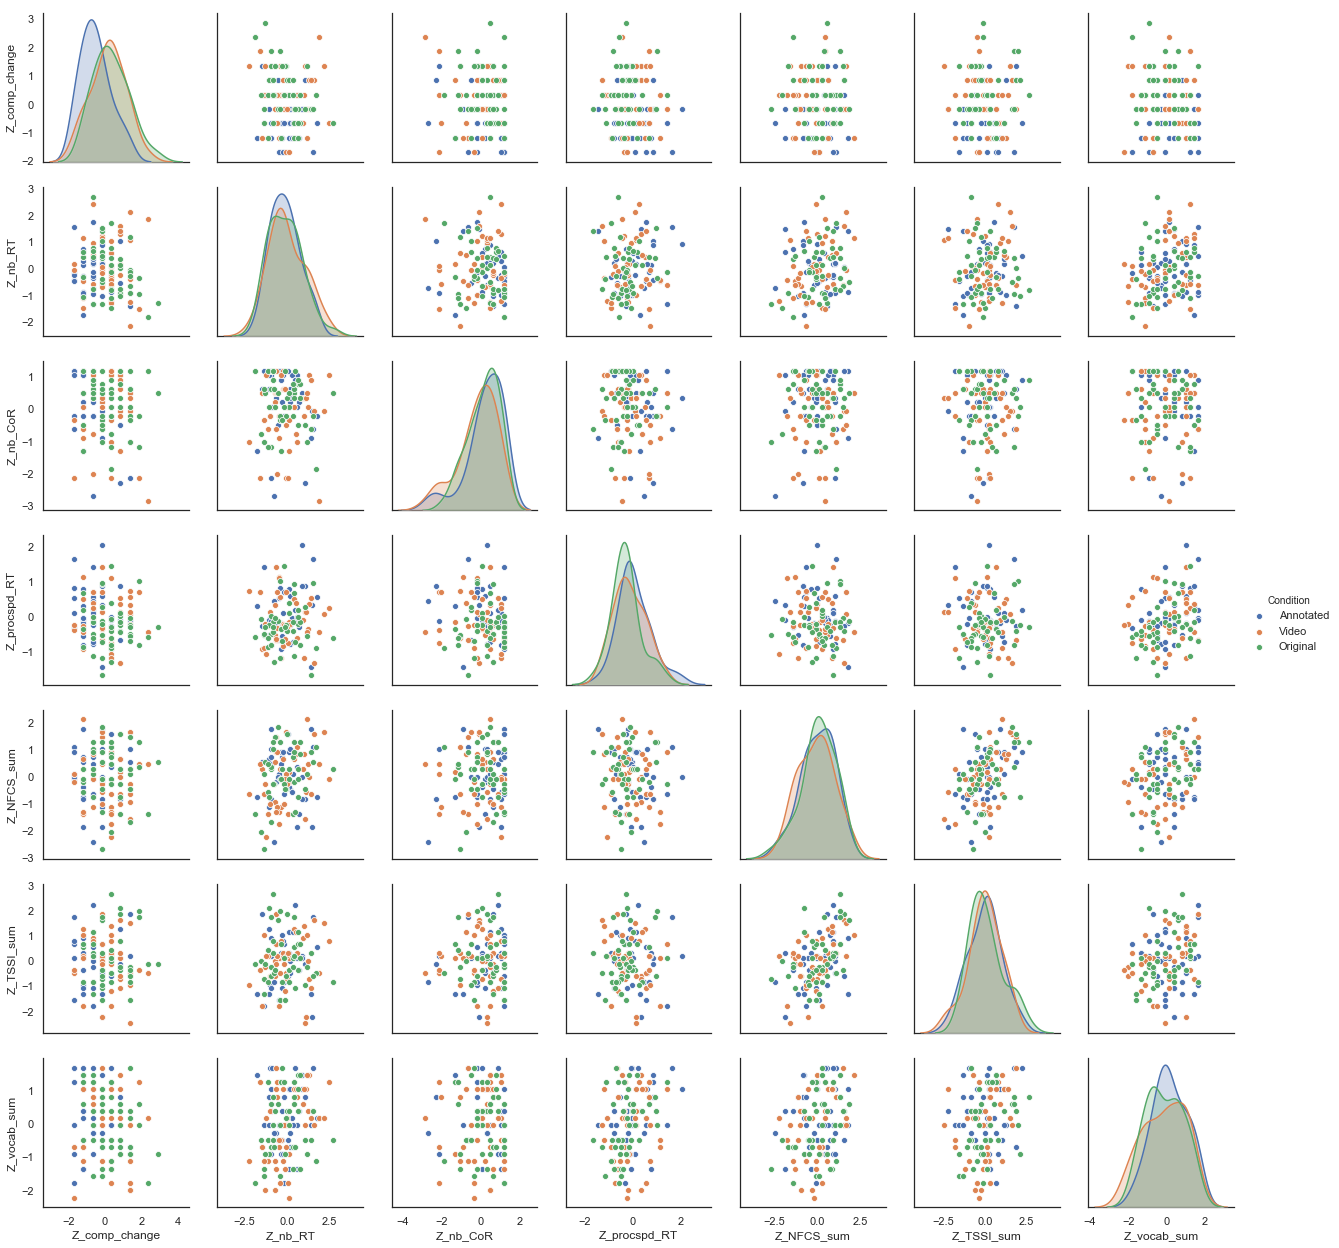

In [50]:
zx_selective_pairplot_condition = sns.pairplot(
    data[['Condition'] + zvars].dropna(), hue='Condition')
figpath = figures_dir / 'Z_selective_pairplot_condition.png'
zx_selective_pairplot_condition.savefig(figpath, bbox_inches='tight')

## Linear Model Plots

In [59]:
zvars

['Z_comp_change',
 'Z_nb_RT',
 'Z_nb_CoR',
 'Z_procspd_RT',
 'Z_NFCS_sum',
 'Z_TSSI_sum',
 'Z_vocab_sum']

In [52]:
def my_lm_plot(x, y='comp_change', x_jitter=0.0, y_jitter=0.3, hue='AgeGroup', data=data):
    fig = sns.lmplot(data=data, hue=hue, x=x, y=y,
                     x_jitter=x_jitter, y_jitter=y_jitter)
    figpath = figures_dir / ('lm_' +x+ '.png')
    fig.savefig(figpath)

c:\users\ia406477\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


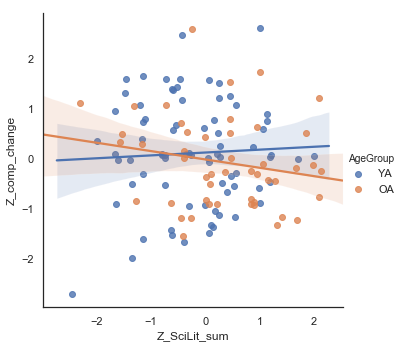

In [53]:
my_lm_plot(x='Z_SciLit_sum', y='Z_comp_change', x_jitter=0.3)

c:\users\ia406477\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


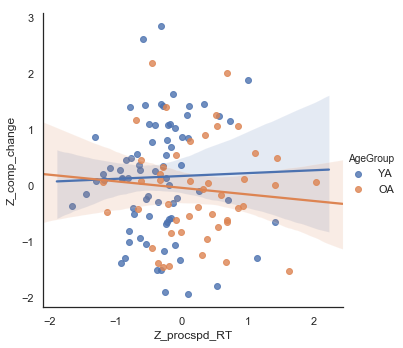

In [54]:
my_lm_plot('Z_procspd_RT', 'Z_comp_change')

c:\users\ia406477\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


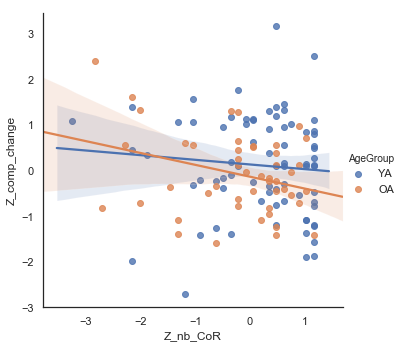

In [60]:
my_lm_plot('Z_nb_CoR', 'Z_comp_change')

c:\users\ia406477\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


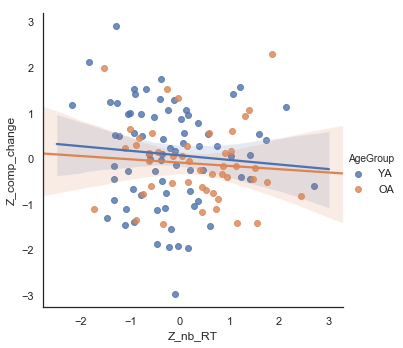

In [55]:
my_lm_plot('Z_nb_RT', 'Z_comp_change')

c:\users\ia406477\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


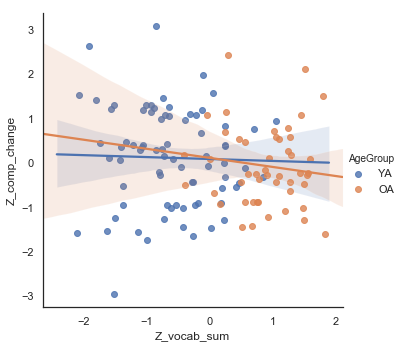

In [56]:
my_lm_plot('Z_vocab_sum', 'Z_comp_change', x_jitter=0.3)

c:\users\ia406477\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


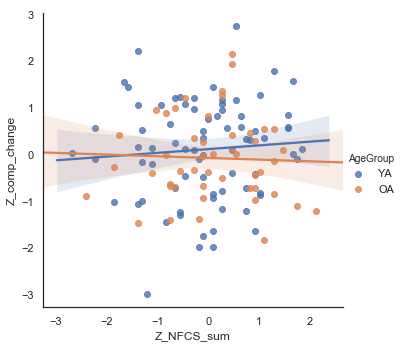

In [57]:
my_lm_plot('Z_NFCS_sum', 'Z_comp_change')

c:\users\ia406477\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


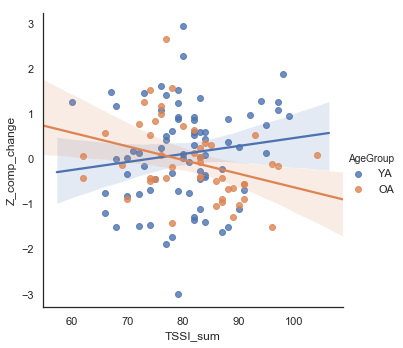

In [58]:
my_lm_plot('TSSI_sum', 'Z_comp_change')

# Horizontal Swarm, Strip, Box, Bar plots

..\..\derivatives\figures\comp_t1_Condition_swarm
..\..\derivatives\figures\comp_t2_Condition_swarm
..\..\derivatives\figures\comp_change_Condition_swarm
..\..\derivatives\figures\nb_CoR_Condition_swarm
..\..\derivatives\figures\nb_RT_Condition_swarm
..\..\derivatives\figures\procspd_RT_Condition_swarm
..\..\derivatives\figures\NFCS_sum_Condition_swarm
..\..\derivatives\figures\TSSI_sum_Condition_swarm
..\..\derivatives\figures\vocab_sum_Condition_swarm
..\..\derivatives\figures\SciLit_sum_Condition_swarm
..\..\derivatives\figures\SciTudeA_sum_Condition_swarm
..\..\derivatives\figures\SciTudeL_sum_Condition_swarm
..\..\derivatives\figures\SciTudeS_sum_Condition_swarm
..\..\derivatives\figures\comp_t1_AgeGroup_swarm
..\..\derivatives\figures\comp_t2_AgeGroup_swarm
..\..\derivatives\figures\comp_change_AgeGroup_swarm
..\..\derivatives\figures\nb_CoR_AgeGroup_swarm
..\..\derivatives\figures\nb_RT_AgeGroup_swarm
..\..\derivatives\figures\procspd_RT_AgeGroup_swarm
..\..\derivatives\figures\

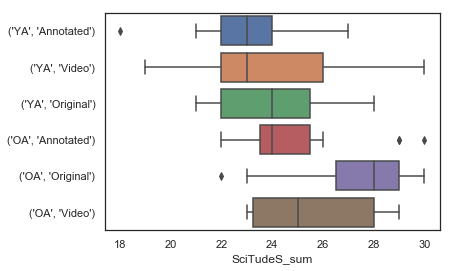

In [56]:
plot_types = { 'swarm':sns.swarmplot, 'box':sns.boxplot }
for p in plot_types.keys():
    for grp in grps_of_interest:
        for var in vars_of_interest:
            try: fig.clear()
            except AttributeError as e: fig=None
            
            fname = var +'_'+ ''.join(grp) +'_'+ p
            fpath = Path('..') / '..' / 'derivatives' / 'figures' / fname
            print(fpath)
            
            df = slim_data.set_index(grp)
            fig = plot_types[p](x=var, y=df.index, data=df)
            fig.get_figure().savefig(fpath, bbox_inches='tight')